# Stock Trading using Actor Critic Model



In [8]:
#imports
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

#for the trading environment
import gym
from gym import error, spaces, utils
from gym.utils import seeding

#for the models
import tensorflow as tf
import tensorflow.keras.layers as kl

## Data Collection

In [9]:
class DataSource(object):
    def __init__(self, data1, data2):
        self.d1 = pd.read_csv(data1)
        self.d2 = pd.read_csv(data2)

        self.d1 = self._prep_dataframe(self.d1)
        self.d2 = self._prep_dataframe(self.d2)

        self.trading_day = 0

        self.starting_date = max(min(self.d1['Date']), min(self.d2['Date'])) # highest start date
        self.end_date      = min(max(self.d1['Date']), max(self.d2['Date'])) # lowest end date

        self._trading_days = (self.end_date-self.starting_date).days

    def __iter__(self):
        self.trading_day = 0
        return self

    def __next__(self):
        while self.trading_day != self._trading_days:
            date = self.starting_date+timedelta(days=self.trading_day)
            self.trading_day += 1

            _s1 = self.d1[self.d1['Date']==date]
            _s2 = self.d2[self.d2['Date']==date]

            if _s1.shape[0] != 1: continue
            if _s2.shape[0] != 1: continue

            s1 = _s1.iloc[0]
            s2 = _s2.iloc[0]

            # Calculate percentage change in stock price
            s1_percent_change = (s1.Close - s1.Open) / s1.Open
            s2_percent_change = (s2.Close - s2.Open) / s2.Open

            return (date, np.array([s1.Close, s2.Close, s1_percent_change, s2_percent_change], dtype=np.float))
        raise StopIteration

    def _prep_dataframe(self, df):
        df['Date'] = pd.to_datetime(df['Date'])

        df = df[['Date','Open', 'Close']]
        return df

    def reset(self):
        self.trading_day = 0

#if __name__=="__main__":
#    ds = DataSource("C:/Users/schee/Desktop/Cits4404/Final/cits4404project/data/AAPL.csv", "C:/Users/schee/Desktop/Cits4404/Final/cits4404project/data/EOD-HD.csv")
#    for date, data in ds: print(date, data)
#    ds.reset()
#    print(next(ds))

## Data cleaning

In [10]:
ds = DataSource("C:/Users/schee/Desktop/Cits4404/Final/cits4404project/data/AAPL.csv", "C:/Users/schee/Desktop/Cits4404/Final/cits4404project/data/EOD-HD.csv")
df = pd.DataFrame(columns=["Date", "S1 Close", "S2 Close", "S1 Change", "S2 Change"])

for date, data in ds:
    df = df.append({
     "Date": date,
     "S1 Close":  data[0],
     "S2 Close":  data[1],
     "S1 Change":  data[2],
     "S2 Change":  data[3],
      }, ignore_index=True)
    
df.head()
ds.reset()

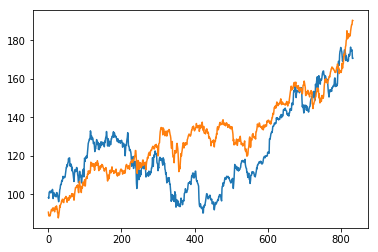

In [11]:
S1_price = df["S1 Close"]
S2_price = df["S2 Close"]
plt.plot(range(0, len(S1_price)), S1_price)
plt.plot(range(0, len(S2_price)), S2_price)

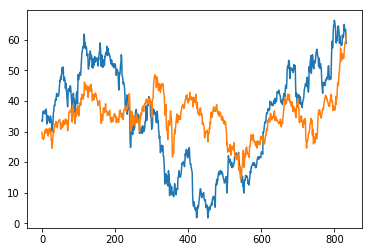

In [12]:
from scipy import signal
s1_detrend = signal.detrend(S1_price) + 35.
s2_detrend = signal.detrend(S2_price) + 35.

plt.plot(range(0, len(S1_price)), s1_detrend)
plt.plot(range(0, len(S2_price)), s2_detrend)

# Set up the environment

In [13]:
class MarketMetrics(object):
    def __init__(self, window_size=20):
        self._window_size = window_size

        self.window_1 = np.zeros(self._window_size)
        self.window_2 = np.zeros(self._window_size)

        self._i = 0

    def reset(self):
        self.window_1 = np.zeros(self._window_size)
        self.window_2 = np.zeros(self._window_size)

        self._i = 0

    def update(self, stock_price_1, stock_price_2):
        index = self._i % self._window_size
        
        self.window_1[index] = stock_price_1
        self.window_2[index] = stock_price_2

        max_stock_1 = max(self.window_1)
        max_stock_2 = max(self.window_2)

        self._i += 1

        data_ready = self._i >= self._window_size
        if not data_ready:
            return 0, False
        else:
            normalised_log_stock_1 = np.log(self.window_1 / max_stock_1)
            normalised_log_stock_2 = np.log(self.window_2 / max_stock_2)
            
            spread = normalised_log_stock_1[index] - normalised_log_stock_2[index]

            return spread, True

# if __name__=='__main__':
#     mm = MarketMetrics(window_size=5)
#     print(mm.update(6, 1))
#     print(mm.update(5, 2))
#     print(mm.update(4, 3))
#     print(mm.update(3, 4))
#     print(mm.update(2, 5))
#     print(mm.update(1, 6))

In [28]:
from enum import Enum

class Status(Enum):
    INVESTED_IN_SPREAD = 1
    OUT_OF_SPREAD = 2

class Actions(Enum):
    BUY = 1
    SELL = 2
    HOLD = 3

class TradingSim(object):
    def __init__(self, start_balance=10000, transaction_fee=10):
        self._start_balance = start_balance
        
        self.transaction_fee = transaction_fee
        self.balance = self._start_balance
        
        self.stock1_balance = 0
        self.stock2_balance = 0

        self.status = Status.OUT_OF_SPREAD
    
    def reset(self):
        self.balance = self._start_balance

        self.stock1_balance = 0
        self.stock2_balance = 0

        self.status = Status.OUT_OF_SPREAD

    def get_NAV(self, stock1_price, stock2_price):
        return self.balance + \
            self.stock1_balance * stock1_price + \
            self.stock2_balance * stock2_price

    def execute(self, action, spread, stock1_price, stock2_price):
        action = Actions(action)
        if action == Actions.BUY:
            if self.status == Status.INVESTED_IN_SPREAD:
                return # Cannot invest if already invested

            # Invest in spread
            if spread < 0:
                # buy stock 1
                self.balance, self.stock1_balance = self.buy(stock1_price)
            else:
                # buy stock 2
                self.balance, self.stock2_balance = self.buy(stock2_price)

            self.status = Status.INVESTED_IN_SPREAD
        elif action == Actions.SELL:
            if self.status == Status.OUT_OF_SPREAD:
                return # Cannot sell if not invested

            if self.stock1_balance > 0:
                # sell stock 1
                self.balance, self.stock1_balance = self.sell(stock1_price, self.stock1_balance)
            elif self.stock2_balance > 0:
                # sell stock 2
                self.balance, self.stock2_balance = self.sell(stock2_price, self.stock2_balance)

            self.status = Status.OUT_OF_SPREAD
        elif action == Actions.HOLD:
            return

    def buy(self, stock_price):
        """Calculates maximum amount of stock that can be bought with
        current cash balance. Returns the new cash and stock balance 
        values.
        
        Arguments:
            stock_price {int} -- Stock price
        Returns:
            (int, int) -- Tuple of new cash balance, and new stock balance
        """

        available_cash_to_spend = self.balance - self.transaction_fee

        max_stocks_to_buy = available_cash_to_spend // stock_price

        new_cash_balance = self.balance - \
            (max_stocks_to_buy * stock_price) - \
            self.transaction_fee

        return (new_cash_balance, max_stocks_to_buy)

    def sell(self, stock_price, stock_balance):
        """Calculates cash balance that is returned when a stock is 
        sold. Returns the new cash and stock balance 
        values.
        
        Arguments:
            stock_price {int} -- Stock price
            stock_balance {int} -- Current stock balance
        Returns:
            (int, int) -- Tuple of new cash balance, and new stock balance
        """

        stock_value = stock_balance * stock_price

        new_cash_balance = self.balance + \
            stock_value - \
            self.transaction_fee

        return (new_cash_balance, 0)


# if __name__=='__main__':
#     ts = TradingSim()
#     ts.execute(1, -0.5, 50, 50)
#     print(ts.get_NAV(50, 50))
#     print(ts.status)

#     ts.execute(2, 0.001, 51, 50)
#     print(ts.get_NAV(51, 50))
#     print(ts.status)


In [29]:
class PairsTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    action_space = spaces.Discrete(3)
    observation_space = spaces.Box(
        low=-1,
        high=1,
        shape=(3,)
    )

    def __init__(self, data_1, data_2):
        super(PairsTradingEnv, self).__init__()
        self.data_source = DataSource(data_1, data_2)
        self.trading_sim = TradingSim()
        self.market_metrics = MarketMetrics()

        self.trading_day = 0

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.data_source.reset()
        self.trading_sim.reset()
        self.market_metrics.reset()

        self.trading_day = 1

        date, data = next(self.data_source)
        s1_price, s2_price, s1_pct, s2_pct = data

        spread, data_ready = self.market_metrics.update(s1_price, s2_price)
        while not data_ready:
            date, data = next(self.data_source)
            s1_price, s2_price, s1_pct, s2_pct = data

            spread, data_ready = self.market_metrics.update(s1_price, s2_price)
            self.trading_day += 1


        return np.array([s1_pct, s2_pct, spread])

    def step(self, action):
        done = 0 
        try:
            date, data = next(self.data_source)
        except StopIteration:
            done = 1
            obs = [0, 0, 0]
            reward = 0
            return obs, reward, done, {}
        s1_price, s2_price, s1_pct, s2_pct = data

        spread, _ = self.market_metrics.update(s1_price, s2_price)

        self.trading_sim.execute(action, spread, s1_price, s2_price)

        self.trading_day += 1

        obs = np.array([s1_pct, s2_pct, spread])
        reward = self.trading_sim.get_NAV(s1_price, s2_price)

        return obs, reward, done, {"date": date, "trading_day": self.trading_day}

# if __name__=='__main__':
#     env = PairsTradingEnv(
#         "C:/Users/schee/Desktop/Cits4404/Final/cits4404project/data/AAPL.csv",
#         "C:/Users/schee/Desktop/Cits4404/Final/cits4404project/data/EOD-HD.csv"
#     )

#     import random

#     print(env.reset())
#     for _ in range(500):
#         obs, reward, done, _ = env.step(random.randint(1,3))

#         if done: break

#         print(obs, reward)


## Setting up the Models

In [65]:
from keras.models import Sequential, Model
class ActorCritic(object):
    """ActorCritic model for continous observation space, and discrete action space
    
    Arguments:
        object {[type]} -- [description]
    
    Returns:
        [type] -- [description]
    """
    def __init__(self, env, **kwargs):
        self.env=env

        self.learning_rate = kwargs.get('learning_rate', 0.001)
        self.gamma = kwargs.get('gamma', 0.99)
        self.saved_actions = []
        self.rewards = []
        self.actor_model  = self._create_actor_model()
        self.critic_model = self._create_critic_model()

    def _create_actor_model(self):
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(self.env.action_space.n, activation='relu', name='policy_logits')
        ])
        model.compile(loss='mse', optimizer='adam')
        return model

    def _create_critic_model(self):
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(1, activation='relu')
        ])
        model.compile(loss='mse', optimizer='adam')

        return model

    def _actor_loss(self, acts_and_advs, logits):
        return 0.0

    def _critic_loss(self, returns, value):
        return 0.0

    def train(self):
        pass
        # self.actor_model.train_on_batch(observations, acts_and_advs)
        # self.critic_model.train_on_batch(observations, returns)

    def predict_action(self, obs):
        logits = self.actor_model.predict(obs[None, :])
        action = tf.squeeze(tf.random.categorical(logits, 1), axis=-1)
        return np.squeeze(action, axis=-1)

In [66]:
env = PairsTradingEnv(
     "C:/Users/schee/Desktop/Cits4404/Final/cits4404project/data/AAPL.csv",
     "C:/Users/schee/Desktop/Cits4404/Final/cits4404project/data/EOD-HD.csv"
)
model = ActorCritic(env)

In [69]:
obs = env.reset()
running_reward = 0
for episode in range(0, 4000):
    obs = env.reset()
    reward = 0
    done = False
    while not done:
        actionProb = model.predict_action(obs)
        action = actionProb.argmax()+1
        obs, reward, done, msg = env.step(action)
        model.rewards.append(reward)
        if done:
            break
        
    running_reward = running_reward * (1 - 1/log_interval) + reward * (1/log_interval)
    finish_episode()
    # Resetting the hidden state seems unnecessary - it's effectively random from the previous
    # episode anyway, more random than a bunch of zeros.
    # model.reset_hidden()
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and running_reward > 500:
        print("Early Stopping: " + str(int(reward)))
        break
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, \
last reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, running_reward))

NameError: name 'torch' is not defined